# Outline:

1. Quantum Jump Monte Carlo: Basic ingredients 

2. Quantum Jump Monte Carlo: Set up the code

3. Apply to two-level system, and compare it with the exact result.

4. Apply the code to interacting atoms, and compare it with the exact result.

# 1. Basics

# Lindblad master equation

$\partial_{t}\rho = -\frac{i}{\hbar}[H,\rho] + \sum \gamma_{i}(L_{i}\rho L_{i}^{+}-\frac{1}{2}(L_{i}L_{i}^{+}\rho + \rho L_{i}L_{i}^{+}))$

# Quantum jump Monte Carlo(QJMC)

$H_{eff} = H - H_{d} = H - \frac{i\hbar}{2}\sum \gamma_{i}L_{i}^{+}L_{i}$

$\delta p = \delta t\bra{\phi(t)}\frac{i}{\hbar}(H_{eff}-H^{\dagger}_{eff}) \ket{\phi(t)}= \delta t\bra{\phi(t)}\sum\gamma_{i}L_{i}^{+}L_{i}\ket{\phi(t)}$, or equivalently

$\delta p =\delta t \cdot tr[\rho\cdot(\sum\gamma_{i}L_{i}^{+}L_{i})] = \sum \delta t\gamma_{i}tr(\rho L_{i}^{+}L_{i}) = \sum\delta p_{i}$

More briefly, total jump probability

$\delta p =-2i \delta t \cdot tr[\rho\cdot H_{d}]$

If random number r > $\delta p$, evolve the state:

$\ket{\phi(t+\delta t)}= \sqrt{\frac{1}{1-\delta p}}(I-\frac{i}{\hbar}H_{eff}\delta t)\ket{\phi(t)}$

If random number r < $\delta p$, apply jump(with probability $\pi_{i}=\frac{\delta p_{i}}{\delta p}$, choose $L_{i}$)

$\ket{\phi(t+\delta t)}= \sqrt{\gamma_{i}\frac{\delta t}{\delta p_{i}}} L_{i}\ket{\phi(t)}$

We can also build the density matrix,

$\ket{\phi(t+\delta t)}\bra{\phi(t+\delta t)} = \gamma_{i}\frac{\delta t}{\delta p_{i}} L_{i}\ket{\phi(t)}\bra{\phi(t)}L^{\dagger}_{i}$

$\ket{\phi(t+\delta t)}\bra{\phi(t+\delta t)} = \frac{1}{1-\delta p}(I-iH_{eff}\delta t)\ket{\phi(t)}\bra{\phi(t)}(I+iH^{\dagger}_{eff}\delta t)$

# 2. Codes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm

Pauli matrices are what we need here to construct H and L's. We first define them in one- and two-body Hilbert space. 

In [3]:
# Define Pauli matrices
identity = np.eye(2, dtype = complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_plus =  np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)


# List of one- and two-body operators A
# A[n-1][m-1] : n-body operators, m-th particle operator
id = [[identity], [np.kron(identity, identity)]]
S_x = [[sigma_x], [np.kron(sigma_x, identity), np.kron(identity, sigma_x)]]
S_plus = [[sigma_plus], [np.kron(sigma_plus, identity), np.kron(identity, sigma_plus)]]
S_minus = [[sigma_minus], [np.kron(sigma_minus, identity), np.kron(identity, sigma_minus)]]



Then quantum states

In [13]:
# Define single-particle states |0> <0| and |1> <1|
rho_gg = np.array([[1, 0], [0, 0]], dtype=complex)
rho_ee = np.array([[0, 0], [0, 1]], dtype=complex)

# List of one- and two-body density matrices rho[n-1][m-1]: n-body density matrix, m-th particle excited
rho_g = [[rho_gg], [np.kron(rho_gg,rho_gg)]]
rho_e = [[rho_ee], [np.kron(rho_ee, identity), np.kron(identity, rho_ee)]]



Build the non-Hermitian Hamiltonian

In [5]:
# Input: (2^n x 2^n matrix)
# Output: (2^n x 2^n matrix)
def dagger(matrix):
    return np.conj(matrix).T

# Input: (2^n x 2^n matrix), (list of 2^n x 2^n matrix), (list of values)
# Output: (2^n x 2^n matrix), (2^n x 2^n matrix), (2^n x 2^n matrix)
def effective_Hamiltonian(H, L_ops, gamma_values):
    
    # Check the system size
    n = len(gamma_values)
    
    # Dissipator
    H_d = np.zeros((2 ** n, 2 ** n), dtype = complex)
    for gamma, L in zip(gamma_values, L_ops):
        L_dagger = dagger(L)
        H_d += 1j/2 * gamma * L_dagger @ L
             
    # Non-Hermitian Hamiltonian = H - Hd
    H_eff = H -  H_d
    H_eff_dagger = dagger(H_eff)
    
    return H_eff, H_eff_dagger, H_d

Then, build a function which calculate $\delta p = \sum \delta p_{i}$ and pick a $L_{i}$ according to the relative probability $\pi_{i} = \frac{\delta p_{i}}{\delta p}$.

In [8]:
# Input: 
# quantum states(2^n x 2^n matrix), jump operators L(list of 2^n x 2^n matrix),
# decay rate(list of values), dt(value)
# Output: 
# jump probability(value), chosen_gamma(value), 
# chosen L(2^n x 2^n matrix), chosen_dp(value)
def quantum_jump_probabilities(rho, L_ops, gamma_values, dt):
    dp_values = []
    
    for L, gamma in zip(L_ops, gamma_values):
             
        # Calculate dp_i = gamma_i * trace(rho * L^+_i * L_i)
        dp = dt * gamma * np.trace(rho @ dagger(L) @ L)
        dp = np.real(dp)
        dp_values.append(dp)
        
    # calculate dp and normalized dp_i
    dp_total = np.sum(dp_values)
    if dp_total != 0:
        normalized_dp_values = [x / dp_total for x in dp_values]
        # Pick a gamma_i and a L_i
        chosen_index = np.random.choice(len(L_ops), p=normalized_dp_values)
        chosen_gamma = gamma_values[chosen_index]
        chosen_L = L_ops[chosen_index]
        chosen_dp = dp_values[chosen_index]
    else:
        normalized_dp_values = chosen_gamma = chosen_L = chosen_dp = None  
      

    return dp_total, chosen_gamma, chosen_L, chosen_dp

# --------------------------Test case --------------------------
rho = rho_e[0][0]
L_ops = [S_minus[0][0]]  
gamma_values = [5]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(rho, L_ops, gamma_values, dt)

    print("Total Jump Probability, chosen_gamma, chosen_L, chosen_dp are: ", dp_data[0], dp_data[1], dp_data[2], dp_data[3])

rho = rho_g[0][0]
L_ops = [S_minus[0][0]]  
gamma_values = [5]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(rho, L_ops, gamma_values, dt)

    print("Total Jump Probability, chosen_gamma, chosen_L, chosen_dp are: ", dp_data[0], dp_data[1], dp_data[2], dp_data[3])

rho = rho_g[1][0]
L_ops = [S_minus[1][0], S_minus[1][1]]  
gamma_values = [5,8]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(rho, L_ops, gamma_values, dt)

    print("Total Jump Probability, chosen_gamma, chosen_L, chosen_dp are: ", dp_data[0], dp_data[1], dp_data[2], dp_data[3])

# --------------------------End of test case --------------------------



Total Jump Probability, chosen_gamma, chosen_L, chosen_dp are:  0.0 None None None
Total Jump Probability, chosen_gamma, chosen_L, chosen_dp are:  0.005 5 [[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]] 0.005
Total Jump Probability, chosen_gamma, chosen_L, chosen_dp are:  0.013000000000000001 8 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]] 0.008


Then, build a function to simulate trajectories of n particles(or n modes).

In [18]:
# Input : 
# initial state(2^n x 2^n matrix), Hamiltonian(2^n x 2^n matrix),
# jumps(list of 2^n x 2^n matrices), decay rate(list of values), 
# total_time(value), dt(value)

# Output : 
# [0] : time-evolved states(list of 2^n x 2^n matrix)
# [1][i-1] : time-evolved excitation density of i-th particle(list of values)
def single_simulation(rho, H, L_ops, gamma_values, total_time, dt):
    
    # Check the system size
    n = len(gamma_values)
    
    # Storage for the density matrices for all time 
    state_ops = [] 
    
    # Storage for each particle's excitation densities for all time  
    n_e_values = [[] for _ in range(n)] 

    # Storage for time
    time_values = []

    # Set up initial condition Rho(t=0) 
    current_time = 0
    current_state = rho

    # Counting jumps
    jump_num = 0
             
    # Set-up non-Hermitian Hamiltonian
    H_eff, H_eff_dagger, H_d = effective_Hamiltonian(H, L_ops, gamma_values)
    
    # Evolve the state
    while current_time < total_time:
        
        # Record current quantum state and time
        state_ops.append(current_state)
        time_values.append(current_time)
        
        # Record current excitation density of each particle
        for i in range(n):
            n_e = np.trace(rho_e[n-1][i] @ current_state)
            n_e_values[i].append(n_e)

        # Calculate jump probability, pick a L_i along with gamma_i and dp_i 
        dp_data = quantum_jump_probabilities(current_state, L_ops, gamma_values, dt)
        dp_total = dp_data[0]
        chosen_gamma = dp_data[1]
        chosen_L = dp_data[2]
        chosen_dp = dp_data[3]
        
        # Check jump condition
        jump_occurs = np.random.rand() < dp_total

        # Propagate the state 
        if jump_occurs:
            jump_num += 1
            current_state = dt/chosen_dp * chosen_gamma * chosen_L @ current_state @ dagger(chosen_L)
        else:
            current_state = 1/(1-dp_total)*(id[n-1][0] - 1j * dt * H_eff) @ current_state @ (id[n-1][0] + 1j * dt * H_eff_dagger)
        
        # update time
        current_time += dt
        
    
    return state_ops, n_e_values, time_values


# Output:
# [0][m-1] : time-evolved states in m-th trajectory (list of 2^n x 2^n matrix)
# [1][m-1][i-1] : time-evolved excitation density of i-th particle in m-th trajectory (list of values)
def multiple_simulations(N, rho, H, L_ops, gamma_values, total_time, dt):

    # Storage for data from each single simulation
    state_ops = []
    n_e_values = []

    for _ in range(N):
        
        single_simulation_result = single_simulation(rho, H, L_ops, gamma_values, total_time, dt)
        state_ops.append(single_simulation_result[0])
        n_e_values.append(single_simulation_result[1])

    time_values = single_simulation_result[2]

    return state_ops, n_e_values, time_values



# 3. Two level system

Master equation: 

$\partial_{t}\rho = -i[\Omega\sigma^{x},\rho] + \gamma(\sigma^{-}\rho\sigma^{+}- \frac{1}{2}(\sigma^{+}\sigma^{-}\rho+\rho\sigma^{+}\sigma^{-}))$

This is the Lindbladian form with

$H = \Omega\sigma^{x}$, $L^{\dagger}_i = L^{\dagger} = \sigma^{+}$, $L_i = L = \sigma^{-}$

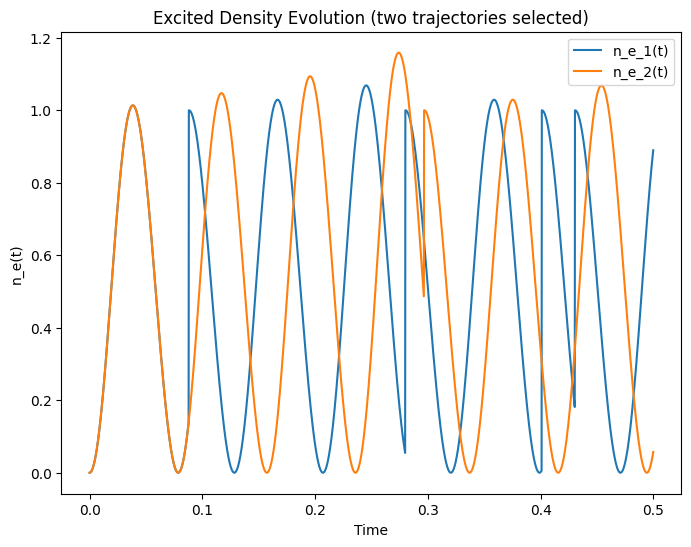

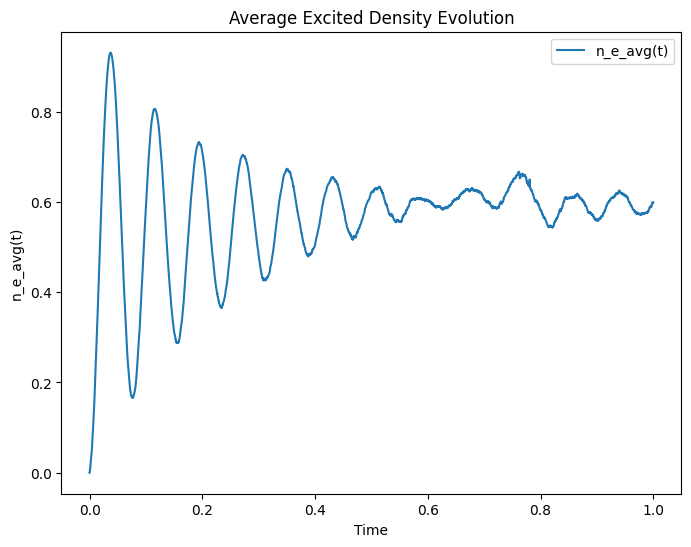

In [22]:
# Define Hamiltonian, jump operators of the two level system (let hbar=1)
omega = 40
H = omega * S_x[0][0]
L_ops = [S_minus[0][0]]
gamma_values = [40/6]

# Set up initial state and time parameters
rho = rho_g[0][0]
total_time = 1.0
dt = 0.0002

# Start N-trajectory simulation
N = 1000
state_ops, n_e_values, time_values = multiple_simulations(N, rho, H, L_ops, gamma_values, total_time, dt)

# Reminder for the outcome data: 
# state_ops = [ {rho(t)}_1, {rho(t)}_2, ...., {rho(t)}_N ]
# n_e_values = [ [{n_e(t)}]_1, [{n_e(t)}]_2, ...., [{n_e(t)}]_N ]
# time_values = [t1, t2,....., t_total]

# Calculate the trajectory-averaged excitation density
n_e_array = []
sum_values = np.zeros(np.shape(n_e_values[0][0]),dtype = complex)
for i in range(N):
    n_e_array.append(np.array(n_e_values[i][0]))
    sum_values += n_e_values[i][0]
    
n_e_avg_array = np.array(sum_values / N)

# Plot the results
plt.figure(figsize=(8,6))

for i in range(2):
    plt.plot(time_values[:len(time_values)//2], n_e_array[i][:len(n_e_array[i])//2], label=f'n_e_{i + 1}(t)')
    
plt.title('Excited Density Evolution (two trajectories selected)')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(time_values, n_e_avg_array, label='n_e_avg(t)')
plt.title('Average Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e_avg(t)')
plt.legend()
plt.show()



# Compared to the exact result

Exactly solve the eigenvalues and eigenvectors of the superoperator 

$L[\rho]=-i[\Omega\sigma^{x},\rho] + \gamma(\sigma^{-}\rho\sigma^{+}- \frac{1}{2}(\sigma^{+}\sigma^{-}\rho+\rho\sigma^{+}\sigma^{-}))$ 

whose matrix representation is 

$
\begin{pmatrix}
    0 & i\Omega & -i\Omega & \gamma\\
    i\Omega & \frac{\gamma}{2} & 0 & -i\Omega\\
    -i\Omega & 0 & -\frac{\gamma}{2} & i\Omega\\
    0 & -i\Omega & i\Omega & 0\\
\end{pmatrix}
\begin{pmatrix}
    \rho_{gg} \\
    \rho_{ge} \\
    \rho_{eg} \\
    \rho_{ee} \\
\end{pmatrix} = \lambda 
\begin{pmatrix}
    \rho_{gg} \\
    \rho_{ge} \\
    \rho_{eg} \\
    \rho_{ee} \\
\end{pmatrix}
$

$\rho(t) = \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ where $\hspace{2em} c_{i} =u^{\dagger}_{i}\rho(0)\hspace{2em}$ 

$\lambda_{1} = 0 \;, \hspace{13em}
\mathbf{u_{1}} = \begin{pmatrix}
    \frac{i\gamma}{2\omega} \\
    1 \\
    1 \\
    0 \\
\end{pmatrix}
 $

$\lambda_{2} = \frac{\gamma}{2} \;,\hspace{13em} 
\mathbf{u_{2}} = \begin{pmatrix}
    1 \\
    \frac{i\gamma}{2\omega} \\
    0 \\
    1 \\
\end{pmatrix}
 $

$\lambda_{3} = \frac{1}{4}(-\gamma-\sqrt{\gamma^{2}-64\omega^{2}}) \;, \hspace{4em} 
\mathbf{u_{3}} = \begin{pmatrix}
    -\frac{\gamma^{2}+16\omega^{2}-\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}} \\
    -\frac{i(-\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega} \\
    \frac{i(3\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega}\\
    1 \\
\end{pmatrix}
 $

$\lambda_{4} = \frac{1}{4}(-\gamma+\sqrt{\gamma^{2}-64\omega^{2}}) \;, \hspace{4em} 
\mathbf{u_{4}} = \begin{pmatrix}
    -\frac{\gamma^{2}+16\omega^{2}+\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}} \\
    \frac{i(\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega} \\
    -\frac{i(-3\gamma+\sqrt{\gamma^{2}-64\omega^{2}})}{8\omega}\\
    1 \\
\end{pmatrix}
 $

Since $\lambda_{1} = 0$, the stationary state $\rho_{ss}$ is established by $u_{1}$.

$n_{e}(\infty)= tr(\ket{e}\bra{e}\rho_{ss})$ can be obtained 

$ tr(\ket{e}\bra{e}\rho_{ss}) = tr(
\begin{pmatrix}
    0 & 0 \\
    0 & 1 \\ 
\end{pmatrix}
\begin{pmatrix}
    \frac{i\gamma}{2\omega} & 1 \\
    1 & 0 \\
\end{pmatrix}) =0
$

The initial state we chose is $\hspace{1em}  \mathbf{\rho(t=0)} = \begin{pmatrix}
    1 \\
    0 \\
    0 \\
    0 \\
\end{pmatrix}\hspace{1em}$, with all these we can easily express the solution by

$\rho(t) = \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ where $\hspace{2em} c_{i} =u^{\dagger}_{i}\rho(0)\hspace{2em}$ and list below

$c_{1} = u^{\dagger}_{1}\rho(0)=-\frac{i\gamma}{2\omega} \hspace{2em} c_{2} = u^{\dagger}_{2}\rho(0)=1 \hspace{2em} c_{3} = u^{\dagger}_{3}\rho(0)=(-\frac{\gamma^{2}+16\omega^{2}-\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}})^{*} \hspace{2em} $

$c_{4} = u^{\dagger}_{4}\rho(0)= (-\frac{\gamma^{2}+16\omega^{2}+\gamma\sqrt{\gamma^{2}-64\omega^{2}}}{16\omega^{2}})^{*}$

The quantity concerns us here is excitation density

$n_{e}(t) = \|\rho^{\dagger}_{e}\rho(t)\|^{2}= \|\begin{pmatrix} 0 & 0 & 0 & 1 \end{pmatrix}(c_{1}e^{\lambda_{1}t}\mathbf{u_{1}}+c_{2}e^{\lambda_{2}t}\mathbf{u_{2}}+c_{3}e^{\lambda_{3}t}\mathbf{u_{3}}+c_{4}e^{\lambda_{4}t}\mathbf{u_{4}}))\|^{2}\hspace{1em}$ which leads us to

$n_{e}(t) = \| \begin{pmatrix} 0 & 0 & 0 & 1 \end{pmatrix} \begin{pmatrix}
    z_{1} \\
    z_{2} \\
    z_{3} \\
    c_{2}e^{\lambda_{2}t}+c_{3}e^{\lambda_{3}t}+c_{4}e^{\lambda_{4}t} \\
\end{pmatrix}\|^{2} = \|c_{2}e^{\lambda_{2}t}+c_{3}e^{\lambda_{3}t}+c_{4}e^{\lambda_{4}t}\|^{2}$

where $z_{1}$, $z_{2}$, $z_{3}$ are known numbers, which can be easily checked, not relevant to our results 

We test the result with the same $\Omega$ and $\gamma$ values as those in the QJMC case we've done.

(0.5021454297888976+6.150881084078977e-32j)
(0.2079593130446915-0.020530520188640072j)
(1.2062542493284036+0.020530520188640017j)
(-0.49700680800094205-0.041168018164049816j)


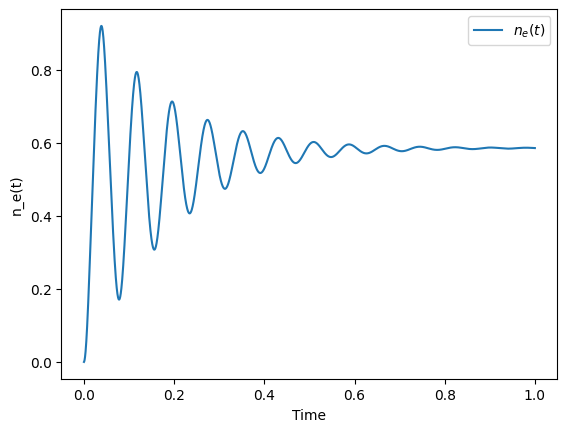

In [23]:
# Define the matrix
Omega = 40
gamma = 40/6

superL = np.array([
    [0, 1j*Omega, -1j*Omega, gamma],
    [1j*Omega, -gamma/2, 0, -1j*Omega],
    [-1j*Omega, 0, -gamma/2, 1j*Omega],
    [0, -1j*Omega, 1j*Omega, 0]
])

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(superL)

# Eigenvalues
lambda1 = eigenvalues[0]
lambda2 = eigenvalues[1]
lambda3 = eigenvalues[2]
lambda4 = eigenvalues[3]
# density matrices from eigenvectors
rho1 = np.array([[eigenvectors[0][0],eigenvectors[0][1]],[eigenvectors[0][2],eigenvectors[0][3]]])
rho2 = np.array([[eigenvectors[1][0],eigenvectors[1][1]],[eigenvectors[1][2],eigenvectors[1][3]]])
rho3 = np.array([[eigenvectors[2][0],eigenvectors[2][1]],[eigenvectors[2][2],eigenvectors[2][3]]])
rho4 = np.array([[eigenvectors[3][0],eigenvectors[3][1]],[eigenvectors[3][2],eigenvectors[3][3]]])

print(np.trace(rho1))
print(np.trace(rho2))
print(np.trace(rho3))
print(np.trace(rho4))

# Initial state
rho_0 = rho_g[0][0]
# Excited state
rho_1 = rho_e[0][0]

# Coefficients of the solution: c1, c2, c3, c4
c1 = np.trace(dagger(rho1)@ rho_0)
c2 = np.trace(dagger(rho2)@ rho_0)
c3 = np.trace(dagger(rho3)@ rho_0)
c4 = np.trace(dagger(rho4)@ rho_0)



parameters = [c1, c2, c3, c4, lambda1, lambda2, lambda3, lambda4, rho1, rho2, rho3, rho4]

# Construct the solution rho(t) of the master equation
def Rho(parameters, t):
    state = parameters[0]*np.exp(parameters[4]*t)*parameters[8] + parameters[1]*np.exp(parameters[5]*t)*parameters[9] + parameters[2]*np.exp(parameters[6]*t)*parameters[10] + parameters[3]*np.exp(parameters[7]*t)*parameters[11]
    # keep normalized
    norm = np.trace(state)
    normalized_state = state / norm
    return normalized_state

t_values = np.linspace(0, 1, 5000)

ne = []
for t in t_values:
    ne.append(np.trace(rho_1@Rho(parameters, t)))

# Plot
t_values = np.linspace(0, 1, 5000)
n_e_values = np.array(ne)
plt.plot(t_values, n_e_values, label=r'$n_e(t)$')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()


Finally, plot the QJMC and exact result together.

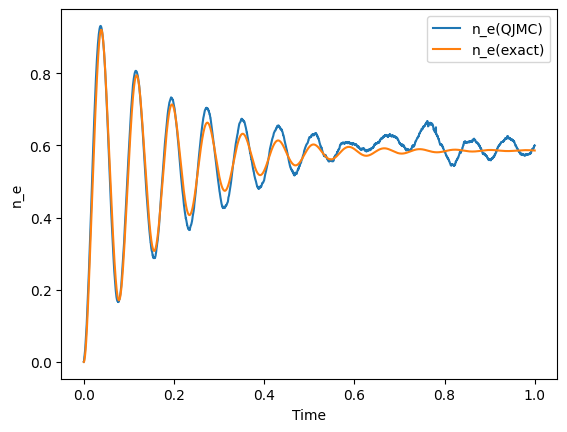

In [31]:
min_length = min(len(time_values), len(n_e_avg_array), len(t_values), len(n_e_values))
n_e_QJMC_aligned = n_e_avg_array[:min_length]
n_e_exact_aligned = n_e_values[:min_length]
time_array_aligned = t_values[:min_length]

plt.plot(time_array_aligned, n_e_QJMC_aligned, label='n_e(QJMC)')
plt.plot(time_array_aligned, n_e_exact_aligned, label='n_e(exact)')

plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

# 4. Interacting-atom system

Master equation: 

$\partial_{t}\rho = -i[\Omega\sum\sigma^{x}_{k},\rho] + \gamma\sum(\sigma^{-}_{k}\rho\sigma^{+}_{m}- \frac{1}{2}(\sigma^{+}_{k}\sigma^{-}_{m}\rho+\rho\sigma^{+}_{k}\sigma^{-}_{m}))$

Diagonalize $\gamma$ we get the Lindblad form with 

$\gamma_{1} = 0$ and $\gamma_{2} = 2\gamma$

$H = \Omega\sum\sigma^{x}_{k}$ , $L_{1} = \frac{1}{\sqrt{2}}\sigma^{-}_{1}-\frac{1}{\sqrt{2}}\sigma^{-}_{2}$ , and $L_{2} = \frac{1}{\sqrt{2}}\sigma^{-}_{1}+\frac{1}{\sqrt{2}}\sigma^{-}_{2}$

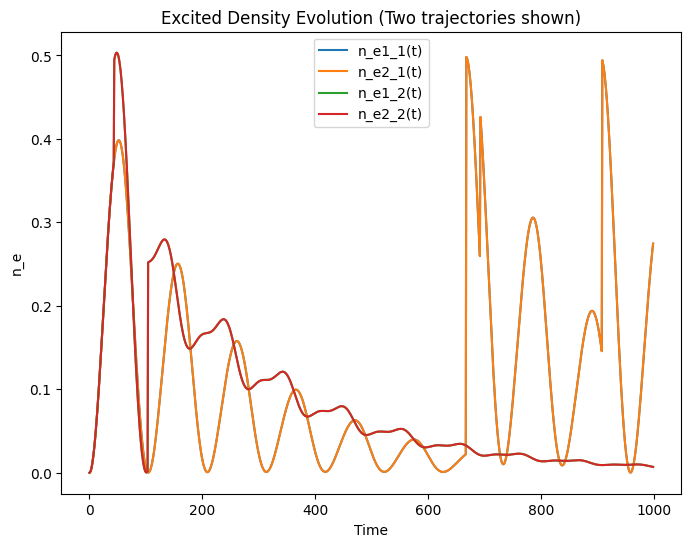

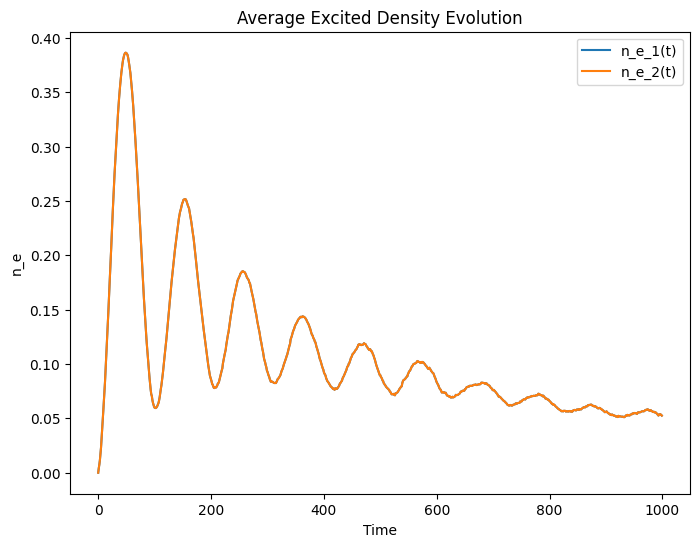

In [473]:
# Define Hamiltonian, jump operators of the interacting-atom system (let hbar=1)
omega = 30
rho = rho_g[1][0]
H = omega * (S_x[1][0]+S_x[1][1]) 
L1 = 1/np.sqrt(2) * (S_minus[1][0] - S_minus[1][1])
L2 = 1/np.sqrt(2) * (S_minus[1][0] + S_minus[1][1])
L_ops = [L1, L2]
gamma_values = [0, 10]
total_time = 1.0
dt = 0.001

# Multiple simulations of trajectory
N = 1000
state_ops, n_e_values = multiple_simulations(N, rho, H, L_ops, gamma_values, total_time, dt)

# Reminder: 
# state_ops = [ {rho(t)}_1, {rho(t)}_2, ..., {rho(t)}_N ]
# n_e_values = [ [{n_e_1(t)}, {n_e_2(t)}]_1, [{n_e_1(t)}, {n_e_2(t)}]_2, ..., [{n_e_1(t)}, {n_e_2(t)}]_N ]
# time_values = [t1, t2,....., t_total], length = 1000


# Average the excitation density over trajectories
n_e_array1 = []
n_e_array2 = []
sum1 = np.zeros(np.shape(n_e_values[0][0]),dtype = complex)
sum2 = np.zeros(np.shape(n_e_values[0][1]),dtype = complex)

for i in range(N):
    n_e_array1.append(np.array(n_e_values[i][0]))
    n_e_array2.append(np.array(n_e_values[i][1]))
    sum1 += n_e_values[i][0]
    sum2 += n_e_values[i][1]
    
n_e_avg_array1 = np.array(sum1/N)
n_e_avg_array2 = np.array(sum2/N)

# Plot the results
plt.figure(figsize=(8,6))
for i in range(2):
    plt.plot(n_e_array1[i], label=f'n_e1_{i + 1}(t)')
    plt.plot(n_e_array2[i], label=f'n_e2_{i + 1}(t)')
    
plt.title('Excited Density Evolution (Two trajectories shown)')
plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(n_e_avg_array1, label = 'n_e_1(t)')
plt.plot(n_e_avg_array2, label = 'n_e_2(t)')

plt.title('Average Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()


# Compared to the exact result

Solve the eigenvalues and eigenvectors of the superoperator 

$ L[\rho] = -i[\Omega\sum\sigma^{x}_{k},\rho] + \gamma\sum(\sigma^{-}_{k}\rho\sigma^{+}_{m}- \frac{1}{2}(\sigma^{+}_{k}\sigma^{-}_{m}\rho+\rho\sigma^{+}_{k}\sigma^{-}_{m}))$

where L is represented by a 16 x 16 matrix as follows

$L_{mn} = -i\Omega [\delta_{m,n\pm 8} + \delta_{m,n\pm 4} - \delta_{m,n\pm 2} - \delta_{m,n\pm 1}] $

$+ \gamma [\delta_{s_{1},1}\delta_{s'_{1},1}\delta_{m,n-10}+\delta_{s_{1},1}\delta_{s'_{2},1}\delta_{m,n-9}+\delta_{s_{2},1}\delta_{s'_{1},1}\delta_{m,n-6}+\delta_{s_{2},1}\delta_{s'_{2},1}\delta_{m,n-5}]$

$ - \frac{\gamma}{2}[(\delta_{s_{1},1}+\delta_{s_{2},1}+\delta_{s'_{1},1}+\delta_{s'_{2},1})\delta_{m,n}+ \delta_{s,0}\delta_{s_{2},1}\delta_{m,n+4}+\delta_{s_{1},1}\delta_{s_{2},0}\delta_{m,n-4}+\delta_{s'_{1},0}\delta_{s'_{2},1}\delta_{m,n+1}+\delta_{s'_{1},1}\delta_{s'_{2},0}\delta_{m,n-1}]$

for the term including $m \pm k$", the criterion is to choose '+' whenever subtracting k makes it less than 0."




Establish this matrix and solve for its eigenvalues and eigenvectors

In [483]:
def L1(m, n):
    if 1 <= m <= 16 and 1 <= n <= 16:
        if n > 8:
            return (m == n - 8) + (m == n - 4) - (m == n - 2) - (m == n - 1)
        elif 4 < n <= 8:
            return (m == n + 8) + (m == n - 4) - (m == n - 2) - (m == n - 1)
        elif 2 < n <= 4:
            return (m == n + 8) + (m == n + 4) - (m == n - 2) - (m == n - 1)
        elif 1 < n <= 2:
            return (m == n + 8) + (m == n + 4) - (m == n + 2) - (m == n - 1)
        elif n == 1:
            return (m == n + 8) + (m == n + 4) - (m == n + 2) - (m == n + 1)
        else:
            return 0
    else:
        return 0

def L2(m, n):
    if 1 <= m <= 16 and 1 <= n <= 16:
        s1, s2, s1Prime, s2Prime = map(int, format(n - 1, '04b'))
        return (
            (s1 == 1) * (s1Prime == 1) * (m == n - 10) +
            (s1 == 1) * (s2Prime == 1) * (m == n - 9) +
            (s2 == 1) * (s1Prime == 1) * (m == n - 6) +
            (s2 == 1) * (s2Prime == 1) * (m == n - 5)
        )
    else:
        return 0

def L3(m, n):
    if 1 <= m <= 16 and 1 <= n <= 16:
        s1, s2, s1Prime, s2Prime = map(int, format(n - 1, '04b'))
        return (
            ((s1 == 1) + (s2 == 1) + (s1Prime == 1) + (s2Prime == 1)) * (m == n) +
            (s1 == 0) * (s2 == 1) * (m == n + 4) +
            (s1 == 1) * (s2 == 0) * (m == n - 4) +
            (s1Prime == 0) * (s2Prime == 1) * (m == n + 1) +
            (s1Prime == 1) * (s2Prime == 0) * (m == n - 1)
        )
    else:
        return 0

L_matrix = np.zeros((16,16), dtype = complex)

for m in range(16):
    for n in range(16):

        L_matrix[m][n] = -1j*L1(m+1,n+1) + gamma*L2(m+1,n+1) - gamma/2*L3(m+1,n+1)



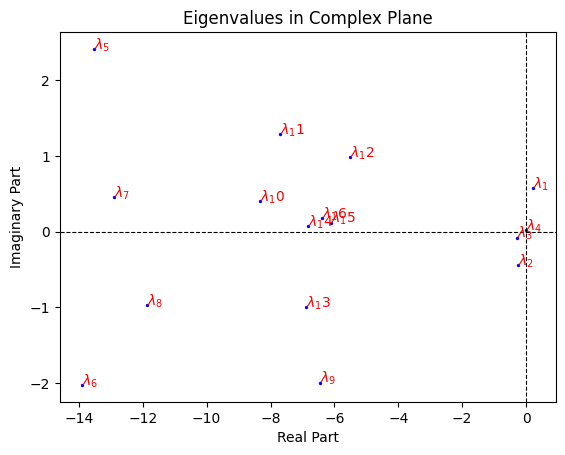

In [484]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(L_matrix)

# Set up density matrices rho from eigenvectors v
rho_ = []
for v in eigenvectors:
    rho_.append(np.reshape(v, (4, 4)))

# Plot the eigenvalues on complex plane.
real_parts = np.real(eigenvalues)
imag_parts = np.imag(eigenvalues)
plt.scatter(real_parts, imag_parts, color='blue', s=2)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues in Complex Plane')

for i, txt in enumerate(eigenvalues):
    plt.annotate(f'$\lambda_{i+1}$', (real_parts[i], imag_parts[i]), color='red')

# plot imaginary part axis
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# plot real part axis
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()

In the plot, we can see that $\lambda_{3}$ and $\lambda_{4}$ are the zeros of eigenvalues.

Correspondingly, eigenvectors $v_{3}$ and $v_{4}$ form stationary states $\rho_{ss}$ 

We obtain $n_{e,k}(\infty)= tr(\ket{e}\bra{e}_{k}\rho_{ss})$ by codes and illustrate them by plot.

n_e1 = (0.4230436767793215-0.04262155819142134j)
n_e2 = (0.3436754182520123-0.14669068970819144j)
n_e1 = (0.06366790445799553-0.13742598369862022j)
n_e2 = (0.2750634317643225+0.02883319705453965j)


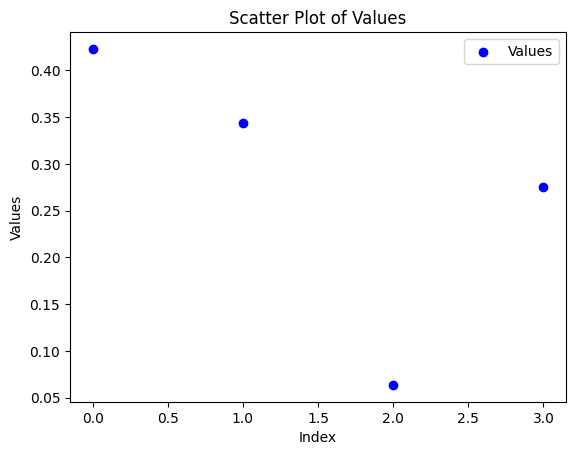

In [492]:
ne_ss1_particle1 = np.trace(rho_e[1][0] @ rho_[2])
ne_ss1_particle2 = np.trace(rho_e[1][0] @ rho_[3])
ne_ss2_particle1 = np.trace(rho_e[1][1] @ rho_[2])
ne_ss2_particle2 = np.trace(rho_e[1][1] @ rho_[3])

print("n_e1 =", ne_ss1_particle1)
print("n_e2 =", ne_ss1_particle2 )
print("n_e1 =", ne_ss2_particle1)
print("n_e2 =", ne_ss2_particle2)

values = [ne_ss1_particle1, ne_ss1_particle2, ne_ss2_particle1, ne_ss2_particle2]
plt.scatter(range(4), values, color='blue', label='Values', marker='o')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of Values')
plt.legend()
plt.show()